In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sn
import torch
import zipfile

In [ ]:
macmorpho_file_url = 'https://www.vareto.com.br/ftp/igti/tagging/macmorpho-v3.zip'

if not os.path.isfile('macmorpho-v3.zip'):
    !wget $macmorpho_file_url
    macmorpho_file = zipfile.ZipFile('macmorpho-v3.zip', 'r')
    macmorpho_file.extractall()

--2023-05-27 12:57:24--  https://www.vareto.com.br/ftp/igti/tagging/macmorpho-v3.zip
Resolving www.vareto.com.br (www.vareto.com.br)... 31.170.167.151, 2a02:4780:1:585:0:142d:d277:1
Connecting to www.vareto.com.br (www.vareto.com.br)|31.170.167.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2311287 (2.2M) [application/zip]
Saving to: ‘macmorpho-v3.zip’

macmorpho-v3.zip    100%[===================>]   2.20M  13.0MB/s    in 0.2s    

2023-05-27 12:57:25 (13.0 MB/s) - ‘macmorpho-v3.zip’ saved [2311287/2311287]



In [ ]:
def read_subset(file_name):
    with open(file_name, 'r', encoding='utf-8') as file_buffer:
        sentences = [row for row in file_buffer]
    return sentences

train_data = read_subset('macmorpho-train.txt')
valid_data = read_subset('macmorpho-dev.txt')
probe_data = read_subset('macmorpho-test.txt')

#1

What is the number of categories (classes) present in each of the sets (training, development and testing)?

In [ ]:
def subset_splitter(data_subset, lower=False):
    data_tuples = list()
    for row in data_subset:
        if lower: row = row.lower()
        tuples_list = row.split()
        tuples_list = [element.split('_') for element in tuples_list]
        tokens_list = [token for (token, label) in tuples_list]
        labels_list = [label for (token, label) in tuples_list]
        data_tuples.append( (tokens_list,labels_list) )
    return data_tuples

def subset_categorizer(data_tuples):
    data_labels = set()
    data_tokens = set()
    for tokens,labels in data_tuples:
        data_labels.update(labels)
        data_tokens.update(tokens)
    return data_labels, data_tokens
        
train_tuples = subset_splitter(train_data, lower=True)
train_labels, train_tokens = subset_categorizer(train_tuples)

valid_tuples = subset_splitter(valid_data, lower=True)
valid_labels, valid_tokens = subset_categorizer(valid_tuples)

probe_tuples = subset_splitter(probe_data, lower=True)
probe_labels, probe_tokens = subset_categorizer(probe_tuples)

assert(len(train_labels) == len(valid_labels) == len(probe_labels))
print(f'All subsets (training, validation and testing) have {len(train_labels)} categories/classes.')

All subsets (training, validation and testing) have 26 categories/classes.


#2

Which category appeared the most times in the training set?

In [ ]:
def vocab_hist_counter(data_tuples, sort=False):
    label_hist = dict()
    vocab_hist = dict()
    for tokens, labels in data_tuples:
        for token in tokens:
            if token in vocab_hist: vocab_hist[token] += 1
            else: vocab_hist[token] = 1
        for label in labels:
            if label in label_hist: label_hist[label] += 1
            else: label_hist[label] = 1            
    if sort: 
        label_hist = sorted(label_hist.items(), key=lambda tup:tup[1], reverse=True)
        vocab_hist = sorted(vocab_hist.items(), key=lambda tup:tup[1], reverse=True)
    else:
        label_hist = list(label_hist.items()) 
        vocab_hist = list(vocab_hist.items())
    return label_hist, vocab_hist

train_label_hist, train_vocab_hist = vocab_hist_counter(train_tuples, sort=True)
print(f'The most present category is  {train_label_hist[0][0].upper()} with {train_label_hist[0][1]} appearances.')
train_label_hist[:10]

The most present category is  N with 156121 appearances.


[('n', 156121),
 ('pu', 106234),
 ('v', 75935),
 ('nprop', 72030),
 ('prep', 70759),
 ('art', 53139),
 ('prep+art', 45690),
 ('adj', 32873),
 ('adv', 18409),
 ('kc', 17908)]

#3

What is the vocabulary size in the training set after typography normalization?

In [ ]:

print(f'The vocabulary has {len(train_tokens)} terms.')


The vocabulary has 47236 terms.


#4

Find the terms that are present in the validation and testing set, but not in the training set.

List the first 5 (five) words, in ascending alphabetical order, that are in the development (validation) set and that are NOT in the training set.
List the first 5 (five) words, in descending alphabetical order, that are in the test (evaluation) set and that are NOT in the training set.

In [ ]:
missing_valid = np.setdiff1d(valid_tokens, train_tokens, assume_unique=True)
missing_valid = sorted(missing_valid[0], reverse=False)
print(f'Missing validation set words: {missing_valid[:10]}')

missing_probe = np.setdiff1d(probe_tokens, train_tokens, assume_unique=True)
missing_probe = sorted(missing_probe[0], reverse=True)
print(f'Missing validation set words: {missing_probe[:10]}')

Missing validation set words: ['!', '"', '%', '&', '&gabbana', "'", '(', ')', ',', '-']
Missing validation set words: ['útil', 'úteis', 'únicos', 'único', 'únicas', 'única', 'úmidas', 'últimos', 'último', 'últimas']


#5

Create a vocabulary with the entire database, that is, including all existing terms in the training, development and test sets.

What is the size of the vocabulary considering the entire database?

In [ ]:
database_vocab = train_tokens | valid_tokens | probe_tokens
print(f'The vocabulary of the entire database has {len(database_vocab)} elements.')

The vocabulary of the entire database has 54235 elements.


#6

Order all elements (types) present in the vocabulary in alphabetical order in order to create a list of words from the entire database in such a way that the identifier of each element will be its respective index. Do the same thing with the labels (categories/classes).


In [ ]:
idx2token = sorted(database_vocab)
print(f'The types found at positions 10000 and 20000 are, respectively {idx2token[10000]} and {idx2token[20000]}.')

idx2label = sorted(train_labels | valid_labels | probe_labels)
print(f'The tags found in positions 10 and 20 are, respectively {idx2label[10].upper()} and {idx2label[20].upper()}.')

The types found at positions 10000 and 20000 are, respectively billpay and draft.
The tags found in positions 10 and 20 are, respectively NUM and PRO-KS.


#7

Given the ordered lists established in the previous question, find the inverted index of both. In other words, generate dictionaries where the word corresponds to the key (key) and index is the value (value).

What are the indices of the words 'bills' and 'draftaram'?
What are the indexes of the 'adv-ks' and 'propess' tags?

In [ ]:
token2idx = {token:idx for (idx,token) in enumerate(idx2token)}
print('The indices found for the words bills and draftaram are, respectively {} and {}.'.format(token2idx['bills'], token2idx['draftaram']))

label2idx = {token:idx for (idx,token) in enumerate(idx2label)}
print('The indices found for the adv-ks and propess tags are, respectively {} and {}.'.format(label2idx['adv-ks'], label2idx['propess']))

The indices found for the words bills and draftaram are, respectively 10001 and 20001.
The indices found for the adv-ks and propess tags are, respectively 2 and 22.


#8

Given that you have generated the inverted dictionary of types (types) in the previous question, find the vector of integers for the following sequence:

In [ ]:
def prepare_sequence(dictionary, sequence):
    num_sequence = [dictionary[item] for item in sequence]
    return torch.tensor(num_sequence, dtype=torch.long)

sentence = ['a', 'imaginação', 'é', 'mais', 'importante', 'que', 'o', 'conhecimento', '.']
num_sent = prepare_sequence(token2idx, sentence)
num_sent.tolist()

[3975, 28725, 54086, 33599, 28931, 42970, 37433, 14798, 49]

#9

Given that you have generated the inverted dictionary of types (types) in the previous question, find the vector of integers for the following sequence:

In [ ]:
tags = ['art', 'n', 'pcp', 'v', 'prep', 'prep', 'prep+art', 'n', 'prep', 'nprop', 'nprop', 'pu']
num_sent = prepare_sequence(label2idx, tags)
num_sent.tolist()

[3, 8, 11, 25, 13, 13, 15, 8, 13, 9, 9, 24]

## Definição da Rede Neural


The following code is for making a very simple LSTM model in PyTorch. The LSTMTagger class subclasses PyTorch's torch.nn.Module class so that it can get all the functionality of the base class. If this is confusing for you, don't worry now, just try it and remember it as a convention in object-oriented languages.

In [ ]:
class LSTMTagger(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        # invoking base class constructor
        super(LSTMTagger, self).__init__()
        # word_embeddings transform one-hot arrays to a compact representation
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        # The lstm takes word embeddings as input and generates hidden states of size hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)
        # hidden2tag is a linear layer that maps from hidden space to tag space.
        self.hidden2tag = torch.nn.Linear(hidden_dim, target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

Above, we established our class that defines the recurrent neural model that will be used: Long short-term memory (LSTM). While in the __init__() constructor we define the LSTMTagger class components, the forward() method specifies how these components relate to each other.

You must employ the LSTMTagger class, provided above, for the rest of this work.

## Definition of Hyperparameters

You must stipulate which values ​​must be provided for VOCAB_SIZE and TARGET_SIZE. However, for others, you must employ the hyperparameters provided above for the rest of this work.

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_DIM    = 64
VOCAB_SIZE    = len(token2idx.keys())
TARGET_SIZE   = len(label2idx.keys())
LEARNING_RATE = 0.05
NUM_EPOCHS    = 5

# Initialize the model with all necessary parameters
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE)

# Empregamos a função de erro denominada Negative Log Likelihood loss (NLLLoss)
loss_function = torch.nn.NLLLoss()

# We employ the Stochastic Gradient Descent (SGD) optimization algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

You must stipulate which values ​​must be provided for VOCAB_SIZE and TARGET_SIZE. However, for others, you must employ the hyperparameters provided above for the rest of this work.

#10

The prepare_sequence(dictionary, sequence) function takes the generated converter dictionary and a list of strings, both for word and label conversion, and returns a numerical equivalent list of type torch.Tensor.

In [ ]:
def prepare_sequence(dictionary, sequence):
    num_sequence = [dictionary[item] for item in sequence]
    return torch.tensor(num_sequence, dtype=torch.long)

The snippet below is a good tip for implementing training of your LSTM network. You should pay attention to the structure of the variables training_data (training set), num_sentence (numeric representation of words), num_tags (numeric representation of tags)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Hardware available: {}'.format(device))

model.to(device)

Hardware available: cpu


LSTMTagger(
  (word_embeddings): Embedding(54235, 128)
  (lstm): LSTM(128, 64)
  (hidden2tag): Linear(in_features=64, out_features=26, bias=True)
)

In [ ]:
print("TRAINING STAGE")
for epoch in range(NUM_EPOCHS):
    print('Current EPOCH: {}/{}'.format(epoch+1, NUM_EPOCHS), end='\t')
    for tokens, labels in train_tuples:
        # Reset gradients so they compute independently
        model.zero_grad()
        #  Transform word vector into numerical vector
        num_tokens = prepare_sequence(token2idx, tokens).to(device)
        #  Transform label vector to numerical vector
        num_labels = prepare_sequence(label2idx, labels).to(device)
        # Transferring data over the network
        pred_labels = model(num_tokens)
        # Find error and optimize recurrent network parameters
        loss = loss_function(pred_labels, num_labels)
        loss.backward()
        optimizer.step()
    # Prevent gradient from updating during validation
    with torch.no_grad():
        record = list()
        for tokens, labels in valid_tuples:
            # Transform word vector into numerical vector 
            num_tokens = prepare_sequence(token2idx, tokens).to(device)
            # Transform label vector to numerical vector 
            num_labels = prepare_sequence(label2idx, labels).to(device)
            # Transferring data over the network
            pred_labels = model(num_tokens)
            # Find most likely tag for each word
            _, max_tags = torch.max(pred_labels, 1)
            # Compute how many words are sorted correctly
            bool_check = [p_label==y_label for (p_label,y_label) in zip(max_tags, num_labels)]
            # Add Calculation to Registry Variable
            record.extend(bool_check)
    print('Validation Accuracy: {}'.format(sum(record)/len(record)))

TRAINING STAGE
Current EPOCH: 1/5	Validation Accuracy: 0.8307656645774841
Current EPOCH: 2/5	Validation Accuracy: 0.8508011698722839
Current EPOCH: 3/5	Validation Accuracy: 0.8621692061424255
Current EPOCH: 4/5	Validation Accuracy: 0.8695763945579529
Current EPOCH: 5/5	Validation Accuracy: 0.8748489022254944


# 11

the code that computes the training and checks the accuracy of the recurrent neural network on the validation data (development) at the end of each epoch was made available. Now, implement its evaluation on the test set remembering to use the torch.no_grad() command.

In what range is the accuracy found in the test set (evaluation)?

In [ ]:
# Impedir que gradiente seja atualizado durante 
y_true = list()
y_pred = list()
with torch.no_grad():
    record = list()
    for tokens, labels in probe_tuples:
        # Transformar vetor de palavras em vetor numérico (semelhante PERGUNTA-08)
        num_tokens = prepare_sequence(token2idx, tokens).to(device)
        # Transformar vetor de etiquetas em vetor numérico (semelhante PERGUNTA-09)
        num_labels = prepare_sequence(label2idx, labels).to(device)
        # Fazer a passagem dos dados pela rede (forward pass)
        pred_labels = model(num_tokens)
        # Encontrar etiqueta com maior probabilidade para cada palavra
        _, max_labels = torch.max(pred_labels, 1)
        # Computar quantas palavras são classificadas de forma correta
        bool_check = [p_label==y_label for (p_label,y_label) in zip(max_labels, num_labels)]
        # Adicionar cálculo à variável de registro
        y_true.extend(num_labels)
        y_pred.extend(max_labels)
        record.extend(bool_check)
print('Evaluation Accuracy: {}'.format(sum(record)/len(record)))

Evaluation Accuracy: 0.859961986541748


# 12

Generate a confusion matrix with the data available for testing. It can be created using the confusion_matrix method from the Sklearn library.

Which labels had the highest incidence of error?

In [ ]:
from sklearn.metrics import confusion_matrix

tags = list(label2idx.keys())
y_true = [idx2label[idx] for idx in y_true]
y_pred = [idx2label[idx] for idx in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred, labels=tags)

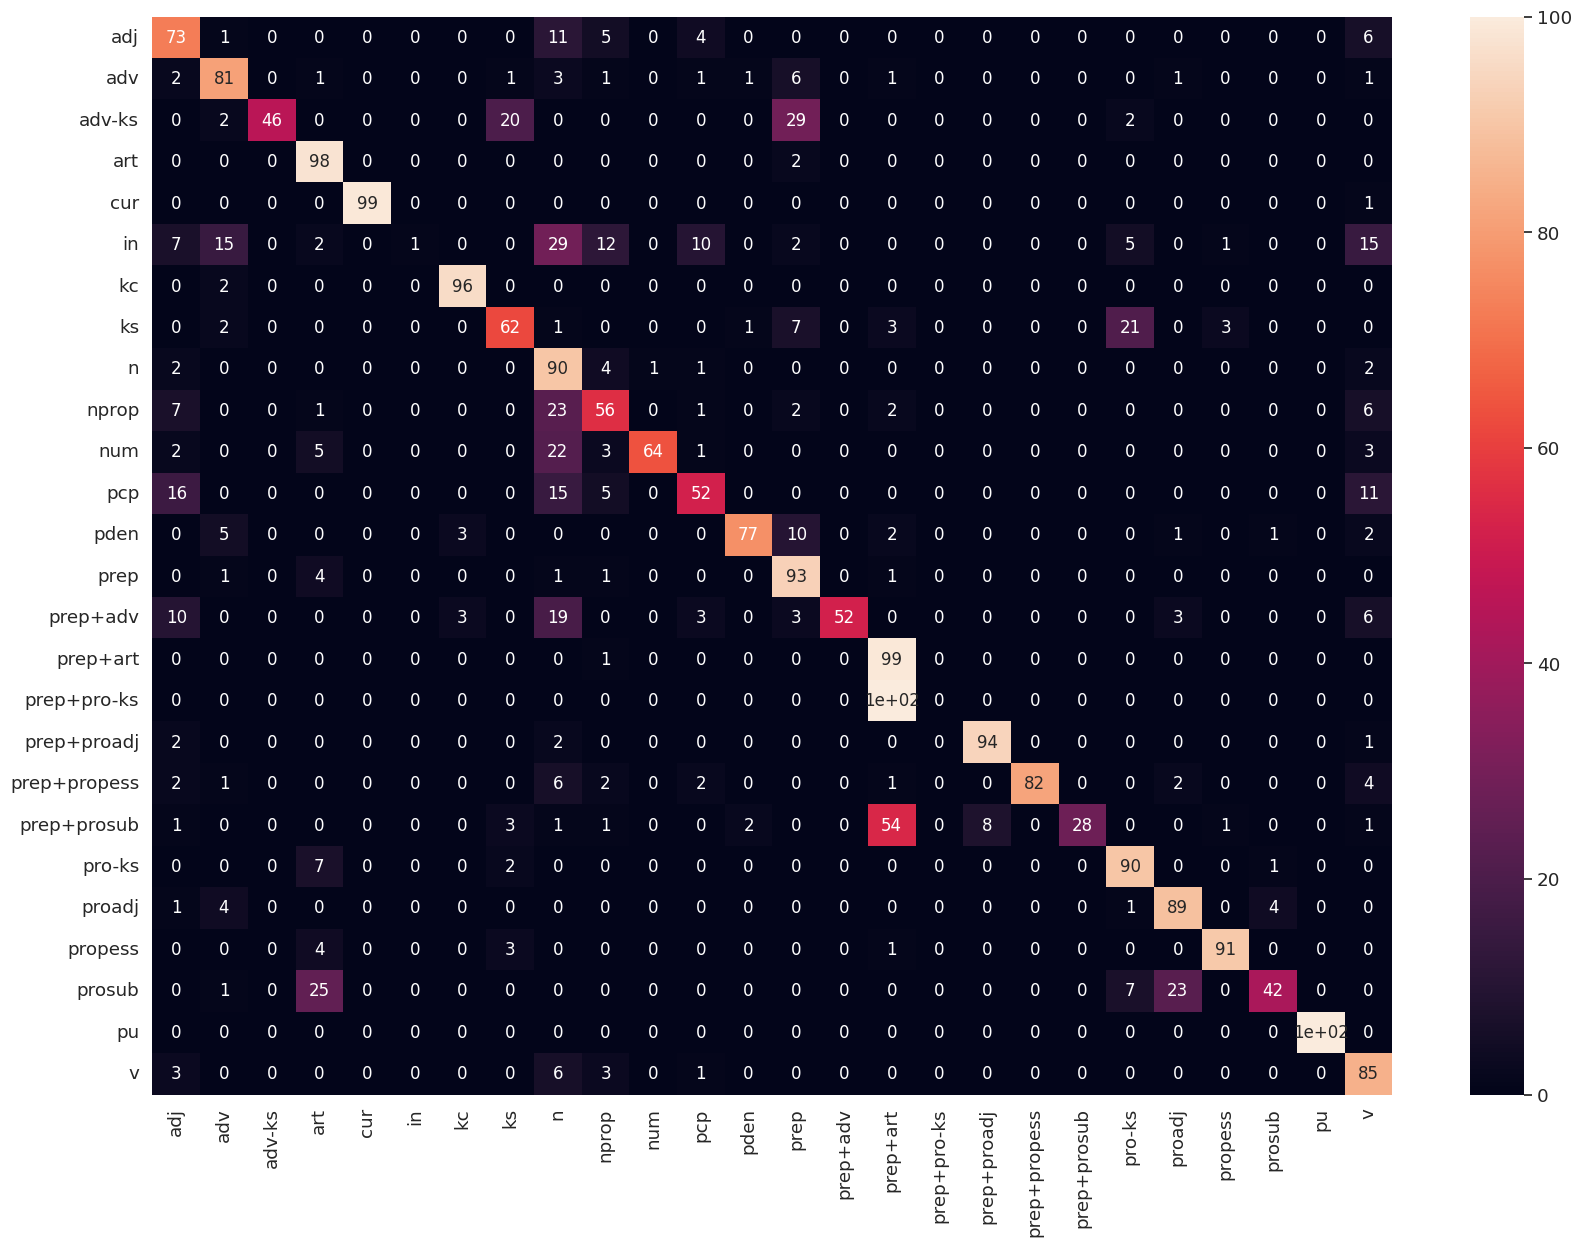

In [ ]:
plt.figure(figsize=(20,14))
df_conf_matrix = pd.DataFrame(conf_matrix, tags, tags)
df_conf_matrix_norm = df_conf_matrix.apply(lambda x: round(100*x/sum(x)), axis = 1)
sn.set(font_scale=1.2)
sn.heatmap(df_conf_matrix_norm, annot=True, annot_kws={"size": 12})
plt.show()

In [ ]:
diagonal = pd.DataFrame(np.diag(df_conf_matrix_norm), index=[df_conf_matrix_norm.index, df_conf_matrix_norm.columns])
diagonal

,,0
adj,adj,73.0
adv,adv,81.0
adv-ks,adv-ks,46.0
art,art,98.0
cur,cur,99.0
in,in,1.0
kc,kc,96.0
ks,ks,62.0
n,n,90.0
nprop,nprop,56.0


In [ ]:
res_tuples = [(tag, pred[0]) for (tag, pred) in zip(tags, diagonal.values.tolist())]
sorted(res_tuples, key=lambda tup:tup[1])

[('prep+pro-ks', 0.0),
 ('in', 1.0),
 ('prep+prosub', 28.0),
 ('prosub', 42.0),
 ('adv-ks', 46.0),
 ('pcp', 52.0),
 ('prep+adv', 52.0),
 ('nprop', 56.0),
 ('ks', 62.0),
 ('num', 64.0),
 ('adj', 73.0),
 ('pden', 77.0),
 ('adv', 81.0),
 ('prep+propess', 82.0),
 ('v', 85.0),
 ('proadj', 89.0),
 ('n', 90.0),
 ('pro-ks', 90.0),
 ('propess', 91.0),
 ('prep', 93.0),
 ('prep+proadj', 94.0),
 ('kc', 96.0),
 ('art', 98.0),
 ('cur', 99.0),
 ('prep+art', 99.0),
 ('pu', 100.0)]